In [1]:
import numpy as np
import matplotlib.pyplot as plt

<span style="font-size:30px;">Load data

Data consists of an array with dimensions 9, where each dimension is one cluster/neuron. Each of these 9 elements are a list, where every element is the time at which that neuron was spiking in ms. Total experiment time is 10 min, hence all numbers are between 0 and 600000.

In [2]:

data = np.load("/run/user/1000/gvfs/smb-share:server=itet-stor.ee.ethz.ch,share=kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/3_Processed_Data/BCM_Test/1821/concatenated/concatenated_SPIKEMAT_ID1821_Network1_Freq40.pkl", allow_pickle=True)
#data = np.load("/run/user/1000/gvfs/smb-share:server=itet-stor.ee.ethz.ch,share=kvulic/neuronies/biohybrid_cmos/spike_sorting/Output/ID1649_N0_DIV14_DATE20240116_1530_spontaneous_.raw_processed.pkl", allow_pickle=True)

In [3]:
data['SPIKEMAT']

array([('11971', 2.5000000e-01, -45.61256409),
       ('12409', 2.5000000e-01, -11.32978344),
       ('11531', 3.5000000e-01, -47.13186646), ...,
       ('14818', 5.0200445e+05, -14.32268715),
       ('12398', 5.0200450e+05, -16.54068756),
       ('14158', 5.0200450e+05, -21.0860939 )],
      dtype=[('Electrode', '<U10'), ('Spike_Time', '<f8'), ('Amplitude', '<f8')])

In [4]:
data['SPIKEMAT'] = np.array([[int(row[0]), float(row[1]), float(row[2])] for row in data['SPIKEMAT']])
data['SPIKEMAT']

array([[ 1.19710000e+04,  2.50000000e-01, -4.56125641e+01],
       [ 1.24090000e+04,  2.50000000e-01, -1.13297834e+01],
       [ 1.15310000e+04,  3.50000000e-01, -4.71318665e+01],
       ...,
       [ 1.48180000e+04,  5.02004450e+05, -1.43226871e+01],
       [ 1.23980000e+04,  5.02004500e+05, -1.65406876e+01],
       [ 1.41580000e+04,  5.02004500e+05, -2.10860939e+01]])

<span style="font-size:30px;">Reshape data

Data is reshaped into an array of shape (TOT_NUM_OF_SAMPLES,2). First column indicates the ID of the electrode (value from 0 to 8) and the second column spike time in ms.

In [9]:
def getMetaInfo(pathToFile: str) -> (np.ndarray,float,float):
    """
    Loads the meta info of a .h5 file.
    :param pathToFile: Filepath.
    :return: The electrode channel mapping as a (2,n_electrodes) matrix. First dimension is (electrodes,channels),
            gain, least significant bit
    """
    rawData = h5py.File(pathToFile, "r")
    gain = np.asarray(rawData["settings"]["gain"])[0]
    lsb = np.asarray(rawData["settings"]["lsb"])[0]
    electrodeInfo = np.asarray(rawData["mapping"]["channel", "electrode"])
    mask = [i["electrode"] != -1 for i in electrodeInfo]
    clean_abs_inds = np.asarray(
        [i[0]["electrode"][i[1]] for i in zip(electrodeInfo, mask)], dtype=np.int32
    )
    clean_rel_inds = np.asarray(
        [i[0]["channel"][i[1]] for i in zip(electrodeInfo, mask)], dtype=np.int32
    )

    # Kick out channels that are used by several electrodes
    _, unique_indices = np.unique(clean_rel_inds, return_index=True)
    if len(unique_indices) != len(clean_rel_inds):
        print(f"{len(clean_rel_inds)-len(unique_indices)} electrodes were removed since they were using the same channel.")
        clean_abs_inds = clean_abs_inds[unique_indices]
        clean_rel_inds = clean_rel_inds[unique_indices]

    electrodeChannelMapping = np.zeros(
        [2, clean_rel_inds.shape[0]], dtype=np.int32
    )

    # First index are the electrode numbers, second the channel where they are stored.
    electrodeChannelMapping[0, :] = np.squeeze(clean_abs_inds)
    electrodeChannelMapping[1, :] = np.squeeze(clean_rel_inds)

    return electrodeChannelMapping, gain, lsb

def convert_elno_to_xy(elno):
    chipWidth = 220
    x = int(elno/chipWidth)
    y = elno % chipWidth
    return x,y

#convert_elno_to_xy(6762), convert_elno_to_xy(16440)

In [5]:
import numpy as np
import os
from typing import List
import h5py

recording_path = '/run/user/1000/gvfs/smb-share:server=itet-stor.ee.ethz.ch,share=kvulic/neuronies/biohybrid_cmos/exp_seed_date_240116/1649/DIV14/spontaneous/1649_DIV_15.raw.h5'
selection_path = '/run/user/1000/gvfs/smb-share:server=itet-stor.ee.ethz.ch,share=kvulic/neuronies/biohybrid_cmos/exp_seed_date_240116/1649/DIV14/spontaneous/selection.npy'
#selection_path = '/home/altiki/Documents/LBB/DATA/CMOS/240607_paper_analysis/selection_N1.npy'
channelMapping, _,_ = getMetaInfo(recording_path)

routing = np.load(selection_path)
routing = routing.flatten()
electrodes = np.where(routing==1)[0]
triggers = np.where(routing>1)[0]
metaInfo = getMetaInfo(recording_path)
channelMapping = metaInfo[0]
mappedElectrodes = channelMapping[0,np.where(np.in1d(channelMapping[0],electrodes))[0]]
channels = channelMapping[1,np.where(np.in1d(channelMapping[0],electrodes))[0]]
elec_coords = np.array([convert_elno_to_xy(i) for i in mappedElectrodes])
channel_to_coord_dict = {'channel': channels, 'x': elec_coords[:,0], 'y': elec_coords[:,1]}
print(triggers)

[]


In [6]:
areas_subselection = np.load('/run/user/1000/gvfs/smb-share:server=itet-stor.ee.ethz.ch,share=kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/2_Raw_Data/Plasticity_Experiments/Electrode_Selections/BCM_Experiments/Network_subselection/Channel_Subselections_ID1821_1_DIV45_electrodes.pkl', allow_pickle=True)


In [7]:
chan_0_elecs = areas_subselection['Channel_0']['Electrodes'][20:50]

In [14]:
x,y = convert_elno_to_xy(6762)
coord = np.where((channel_to_coord_dict['y'] == y) & (channel_to_coord_dict['x'] == x))
coord[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

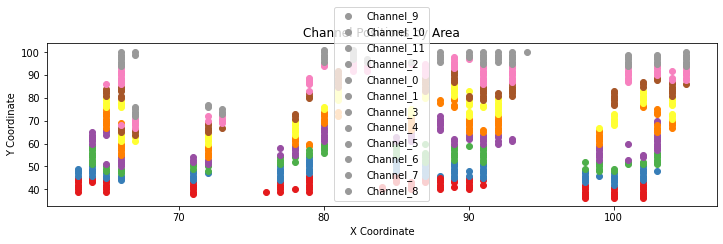

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

items = areas_subselection.keys()


# Get the 'Set1' colormap from matplotlib
set1 = plt.get_cmap('Set1')

# Create a dictionary with each channel having 'Set1' colormap assigned
area_colormaps = {channel: set1 for channel in items}

# Initialize the plot
plt.figure(figsize=(12, 3))

area_to_color = {}
electrode_values = []
color_values = []
# Plot each channel with the appropriate color based on its area
for area in items:
    electrodes = areas_subselection[area]['Electrodes']
    colormap = area_colormaps.get(area, cm.gray)
    num_elecs = len(electrodes)
    colors = [colormap(i / num_elecs) for i in range(num_elecs)]  # Default to black if area is not found in area_colors
    
    #area_to_color[area] = elec_to_color
    electrode_values.extend(electrodes)
    color_values.extend(colors)
    for i,electrode in enumerate(electrodes):
            x,y = convert_elno_to_xy(electrode)
            plt.scatter(y, x, color=colors[i], label=area if i == len(electrodes)-1 else "")

elec_to_color = {'electrode': electrode_values, 'color': color_values}
# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Channel Positions by Area')
#x,y = convert_elno_to_xy(13584)
#plt.scatter(y,x, color='black', marker = 'x')

# Add a legend with unique areas
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Display the plot
plt.show()


<span style="font-size:30px;">Latency plot

In [11]:
def get_latency(spikes, input_electrode_number, output_electrode_number):
    # Filter spikes for input and output electrodes
    input_spikes = spikes[spikes[:, 0] == input_electrode_number]
    output_spikes = spikes[spikes[:, 0] == output_electrode_number]
    
    # Combine and sort spikes by time
    filtered_spikes = np.concatenate((input_spikes, output_spikes))
    sorted_spikes = filtered_spikes[np.argsort(filtered_spikes[:, 1])]

    # Preallocate latency array with an upper bound on size
    max_possible_size = len(input_spikes) + len(output_spikes)
    latency = np.zeros(max_possible_size, dtype=[('input spike', 'i4'), ('spike time', 'i4'), 
                                                 ('latency', 'f4'), ('category', 'U6')])

    input_spike_count = 0
    input_time = None
    index = 0

    for spike in sorted_spikes:
        if spike[0] == input_electrode_number:
            input_time = spike[1]
            latency[index] = (input_spike_count, input_time, 0, "input")
            input_spike_count += 1
            index += 1
        elif spike[0] == output_electrode_number and input_time is not None:
            output_time = spike[1]
            latency[index] = (input_spike_count, output_time, output_time - input_time, "output")
            index += 1

    # Return only the populated part of the latency array
    return latency[:index]

In [23]:
spikes = data['SPIKEMAT']
spikes = spikes[np.isin(spikes[:, 0], chan_0_elecs)]
unique = np.unique(spikes[:,0])
#take only spikes from channel 0
max_spikes = 0
for val in unique:
    spikes_temp = spikes[spikes[:,0] == val]
    if len(spikes_temp) > max_spikes:
        max_spikes = len(spikes_temp)
        print(val, len(spikes_temp))

4105
11504.0 2188
12604.0 2303
12824.0 2587
13044.0 3116
13264.0 4473
16125.0 5009


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

spikes = spikes_temp

input_ids = chan_0_elecs

for input_id in input_ids:

    # Define your electrodes
    input_electrode = np.array([input_id], dtype=float)
    #output_electrodes = spikes[spikes[:, 0] != input_electrode]
    output_electrodes = chan_0_elecs
    #print(output_electrodes)
    

    # Define your constants
    input_color = elec_to_color['color'][np.where(np.array(elec_to_color['electrode']) == input_id)[0][0]] # input electrode spike color 
    
    # Filter spikes for input electrodes
    input_spikes = spikes[spikes[:, 0] == input_electrode]
    #print(input_spikes)
    print(f'Plotting latencies for input {input_electrode}')


    fig1, ax1 = plt.subplots()
    ax1.set_ylabel("Experiment Time (s)")
    ax1.set_xlim((0., 10.))
    ax1.set_xlabel("Latency (ms)")

    # Filter out the input electrode from output electrodes
    #output_electrodes_filtered = output_electrodes[:,0][output_electrodes[:,0] != input_electrode]

    c=0
    # Plotting
    for output_electrode in output_electrodes:
        #print(output_electrode)
        # Get the latency
        latency = get_latency(spikes, input_electrode, output_electrode)

        # Separate input and output spikes
        input_before = latency[latency['category'] == 'input']
        output_before = latency[latency['category'] == 'output']

        # Plot the input spikes on the first iteration
        if c == 0:
            ax1.scatter(input_before['latency'], input_before['spike time'] / 1000, s=7, label='input', color=input_color)
            c+=1
        location = np.where(np.array(elec_to_color['electrode']) == int(output_electrode))
        #print(location)
        if len(location[0]) != 0:
            #print(location)
            output_color = elec_to_color['color'][np.where(np.array(elec_to_color['electrode']) == int(output_electrode))[0][0]]
        #elec_to_color['color'][np.where(np.array(elec_to_color['electrode']) == output_electrode)[0][0]] != 0:
        #output_color = 
        # Plot the output spikes
            ax1.scatter(output_before['latency'], output_before['spike time'] / 1000, s=7, label='output', color=output_color)
    plt.savefig(f"STTRP_input_el_{input_id}.pdf", format = 'pdf')
    plt.show()


In [18]:
def get_latency(spikes, input_electrode_number, output_electrode_number):
    # Filter spikes for input and output electrodes
    input_spikes = spikes[spikes[:, 0] == input_electrode_number]
    output_spikes = spikes[spikes[:, 0] == output_electrode_number]
    
    # Sort spikes by time
    input_spikes = input_spikes[np.argsort(input_spikes[:, 1])]
    output_spikes = output_spikes[np.argsort(output_spikes[:, 1])]

    # Preallocate latency array with an upper bound on size
    max_possible_size = len(input_spikes) + len(output_spikes)
    latency = np.zeros(max_possible_size, dtype=[('input spike', 'i4'), ('spike time', 'i4'), 
                                                 ('latency', 'f4'), ('category', 'U6')])

    input_spike_count = 0
    input_index = 0
    output_index = 0
    index = 0

    # Iterate through both input and output spikes by merge sort technique
    while input_index < len(input_spikes) and output_index < len(output_spikes):
        input_spike_time = input_spikes[input_index][1]
        output_spike_time = output_spikes[output_index][1]
        
        if input_spike_time <= output_spike_time:
            input_time = input_spike_time
            latency[index] = (input_spike_count, input_time, 0, "input")
            input_spike_count += 1
            input_index += 1
        else:
            if input_index > 0:  # There has been at least one input spike
                latency[index] = (input_spike_count, output_spike_time, output_spike_time - input_time, "output")
            output_index += 1
        index += 1

    # Process remaining input spikes
    while input_index < len(input_spikes):
        input_time = input_spikes[input_index][1]
        latency[index] = (input_spike_count, input_time, 0, "input")
        input_spike_count += 1
        input_index += 1
        index += 1

    # Process remaining output spikes
    while output_index < len(output_spikes):
        output_time = output_spikes[output_index][1]
        if input_index > 0:  # There has been at least one input spike
            latency[index] = (input_spike_count, output_time, output_time - input_time, "output")
        output_index += 1
        index += 1

    # Return only the populated part of the latency array
    return latency[:index]


In [33]:
len(areas_subselection['Channel_0']['Electrodes'])

83

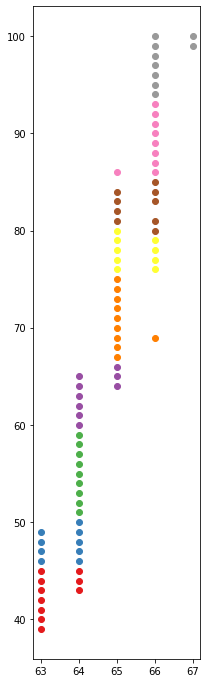

FileNotFoundError: [Errno 2] No such file or directory: '.STTRPs/1821_40Hz/Electrode_color_code.pdf'

<Figure size 432x288 with 0 Axes>

In [37]:
area = 'Channel_0'
electrodes = areas_subselection[area]['Electrodes']
colormap = area_colormaps.get(area, cm.gray)
num_elecs = len(electrodes)
colors = [colormap(i / num_elecs) for i in range(num_elecs)]  # Default to black if area is not found in area_colors

#area_to_color[area] = elec_to_color
electrode_values.extend(electrodes)
color_values.extend(colors)
plt.figure(figsize = (3,12))
for i,electrode in enumerate(electrodes):
        x,y = convert_elno_to_xy(electrode)
        plt.scatter(y, x, color=colors[i], label=area if i == len(electrodes)-1 else "")
plt.show()
plt.savefig(".STTRPs/1821_40Hz/Electrode_color_code.pdf", format = 'pdf')

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming data and unique are already defined
#spikes = data['SPIKEMAT']
spikes = data['SPIKEMAT']
input_ids = chan_0_elecs
output_ids = chan_0_elecs
print(input_ids)
#input_ids = areas_subselection['Channel_0']['Electrodes']

# Convert elec_to_color['electrode'] to numpy array for faster lookups
elec_to_color_electrodes = np.array(elec_to_color['electrode'])
elec_to_color_colors = np.array(elec_to_color['color'])

def get_elec_color(electrode):
    location = np.where(elec_to_color_electrodes == electrode)[0]
    return elec_to_color_colors[location[0]] if len(location) > 0 else None

for input_id in input_ids:
    input_electrode = np.array([input_id], dtype=float)
    input_color = get_elec_color(input_id) # input electrode spike color
    
    input_spikes = spikes[spikes[:, 0] == input_electrode]
    #output_electrodes = spikes[spikes[:, 0] == output_ids]
    output_electrodes = spikes[np.isin(spikes[:, 0], output_ids)]

    output_electrodes_filtered = np.unique(output_electrodes[:, 0])

    print(f'Plotting latencies for input {input_electrode}')

    fig1, ax1 = plt.subplots()
    ax1.set_ylabel("Experiment Time (s)")
    ax1.set_xlim((0., 10.))
    ax1.set_xlabel("Latency (ms)")

    ax1.scatter(input_spikes[:, 1], input_spikes[:, 2] / 1000, s=7, label='input', color=input_color)

    for output_electrode in output_electrodes_filtered:
        output_color = get_elec_color(int(output_electrode))
        if output_color is not None:
            latency = get_latency(spikes, input_electrode, output_electrode)

            input_before = latency[latency['category'] == 'input']
            output_before = latency[latency['category'] == 'output']

            ax1.scatter(output_before['latency'], output_before['spike time'] / 1000, s=7, label='output', color=output_color)
            plt.savefig(f'./STTRPs/1821_40Hz/STTRP_input_el_{input_id}_output_el{output_electrode}.pdf', format = 'pdf')

    plt.savefig(f"STTRP_input_el_{input_id}.pdf", format='pdf')
    plt.show()


[11504, 11724, 11944, 12164, 12384, 12604, 12824, 13044, 13264, 13484, 13704, 13924, 14144, 14145, 14364, 14365, 14585, 14805, 15025, 15245, 15246, 15465, 15685, 15905, 16125, 16345, 16565, 16785, 16786, 17005]
Plotting latencies for input [11504.]
